### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### OCV vs. SOC Data

In [2]:
# Format the data
_ = pd.read_csv('./data/SOC_OCV_MFCTT_2019.csv', sep='\t', names=['SOC', 'Ecell/V'], skiprows=1).astype(float)
_.to_csv('./data/SOC_OCV_MFCTT_2019_delim.csv', index=False)

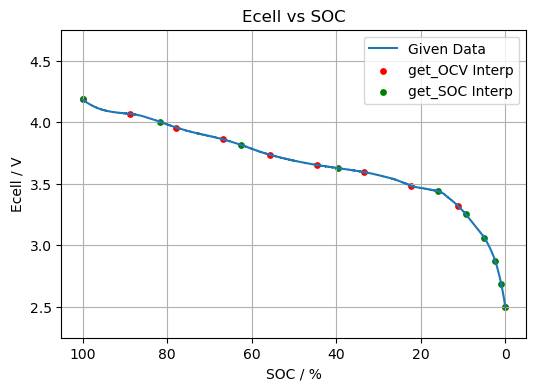

In [3]:
# Load the formatted OCV_DATA csv file
OCV_DATA = pd.read_csv('./data/SOC_OCV_MFCTT_2019_delim.csv')
SOC_DATA = OCV_DATA['SOC'].values
ECELL_DATA = OCV_DATA['Ecell/V'].values

# Returns the open circuit voltage of the battery as a function of the state of charge
def get_OCV(SOC):
    SOC_array = np.array(SOC)
    if np.any(SOC_array < 0) or np.any(SOC_array > 100):
        raise ValueError('SOC must be between 0 and 100')
    # Linear interpolation of the data
    return np.interp(SOC_array, SOC_DATA[::-1], ECELL_DATA[::-1])

# Returns the state of charge of the battery as a function of the open circuit voltage
def get_SOC(Ecell):
    Ecell_array = np.array(Ecell)
    if np.any(Ecell_array < 2.5) or np.any(Ecell_array > 4.2):
        raise ValueError('Ecell must be between 2.5 and 4.2')
    # Linear interpolation of the data
    return np.interp(Ecell_array, ECELL_DATA[::-1], SOC_DATA[::-1])

# Demonstrate the function
SOC_interp1 = np.linspace(0, 100, 10)
Ecell_interp1 = get_OCV(SOC_interp1)

Ecell_interp2 = np.linspace(2.5, 4.19, 10)
SOC_interp2 = get_SOC(Ecell_interp2)

# Plot
fig = plt.figure(figsize=(6, 4))
plt.plot(OCV_DATA['SOC'], OCV_DATA['Ecell/V'], label='Given Data')
plt.scatter(SOC_interp1, Ecell_interp1, s=15, c='r', label='get_OCV Interp')
plt.scatter(SOC_interp2, Ecell_interp2, s=15, c='g', label='get_SOC Interp')
plt.title('Ecell vs SOC')
plt.xlabel('SOC / %')
plt.ylabel('Ecell / V')
plt.ylim(2.25, 4.75)
plt.gca().invert_xaxis() # Invert x-axis
plt.legend()
plt.grid()
plt.show()

### Thevenin Model

#### R0 Calculation

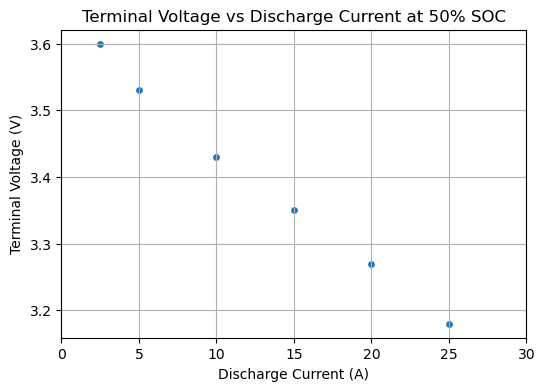

In [4]:
dis_current_array_DATA = np.array([2.5, 5, 10, 15, 20, 25])
TERMINAL_VOLTAGE_DATA = np.array([3.60, 3.53, 3.43, 3.35, 3.27, 3.18])

# Plot
fig = plt.figure(figsize=(6, 4))
plt.scatter(dis_current_array_DATA, TERMINAL_VOLTAGE_DATA, s=15)
plt.title('Terminal Voltage vs Discharge Current at 50% SOC')
plt.xlabel('Discharge Current (A)')
plt.ylabel('Terminal Voltage (V)')
plt.xlim(0, 30)
plt.grid()
plt.show()

In [5]:
current_diff = [i-dis_current_array_DATA[0] for i in dis_current_array_DATA[1:]]
voltage_diff = [v-TERMINAL_VOLTAGE_DATA[0] for v in TERMINAL_VOLTAGE_DATA[1:]]

resistances = np.abs(np.array(voltage_diff) / np.array(current_diff))
R0 = np.mean(resistances)

print(f'R0 = {round(R0, 3)} Ω')

R0 = 0.022 Ω


#### Model Definition

In [6]:
# Thevenin Model, v_term(t) = OCV(SOC(t)) - i(t) * R0
def TheveninModel(SOC, i):
    SOC = np.array(SOC)
    i = np.array(i)
    if i.size != SOC.size:
        raise ValueError('SOC and i must have the same size')
    OCV = get_OCV(SOC)
    return OCV - i * R0    

### Battery Testing Data

       Time (s)  Current (mA)  Voltage (V)  Temperature
1           1.0           0.0         4.05        21.96
2           2.0           0.0         4.05        21.94
3           3.0           0.0         4.05        21.94
4           4.0           0.0         4.05        21.93
5           5.0           0.0         4.05        21.93
...         ...           ...          ...          ...
23427   23427.0           0.0         3.58        20.13
23428   23428.0           0.0         3.58        20.13
23429   23429.0           0.0         3.58        20.13
23430   23430.0           0.0         3.58        20.13
23431   23431.0           0.0         3.58        20.13

[23431 rows x 4 columns]


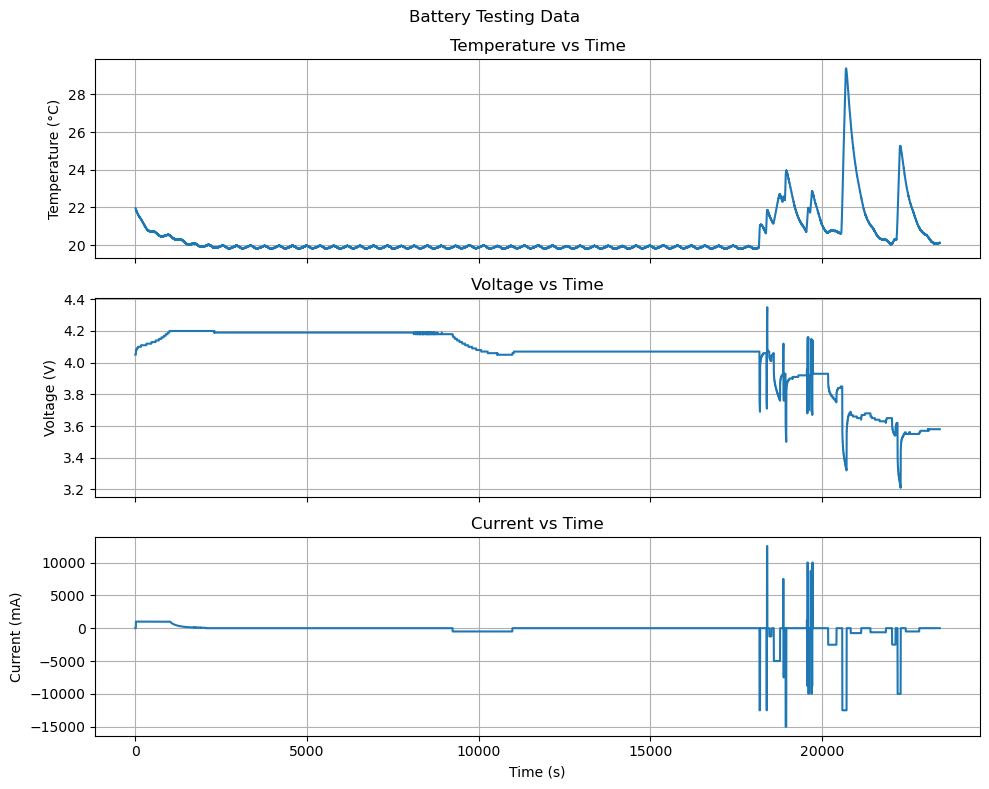

In [7]:
# Load data
BT_DATA = pd.read_csv('./data/Battery_Testing_Data.csv')
BT_DATA = BT_DATA.dropna()  # Drop NaN values
print(BT_DATA)

# Plot the data
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(BT_DATA['Time (s)'], BT_DATA['Temperature'])
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature vs Time')

axs[1].plot(BT_DATA['Time (s)'], BT_DATA['Voltage (V)'])
axs[1].set_ylabel('Voltage (V)')
axs[1].set_title('Voltage vs Time')

axs[2].plot(BT_DATA['Time (s)'], BT_DATA['Current (mA)'])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Current (mA)')
axs[2].set_title('Current vs Time')

for ax in axs:
    ax.grid(True)
plt.suptitle('Battery Testing Data')
plt.tight_layout()
plt.show()

#### Discharge Data

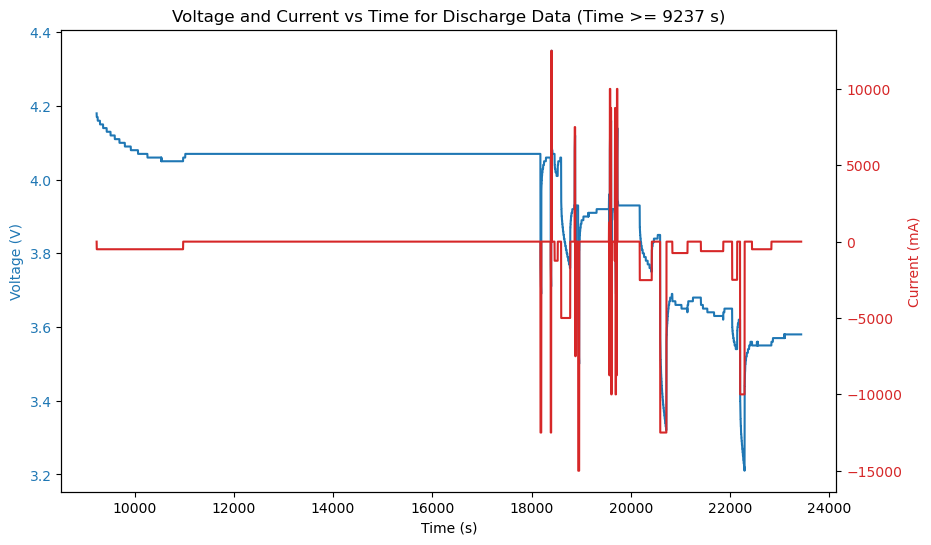

In [8]:
# Slice BT_discharge data
BT_discharge = BT_DATA[BT_DATA['Time (s)'] >= 9237]

# plot voltage and current in the same plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)', color='tab:blue')
ax1.plot(BT_discharge['Time (s)'], BT_discharge['Voltage (V)'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Current (mA)', color='tab:red')
ax2.plot(BT_discharge['Time (s)'], BT_discharge['Current (mA)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Voltage and Current vs Time for Discharge Data (Time >= 9237 s)')
plt.show()

### Application

#### Calculate SOC(t) by Coulomb Counting

Starting SOC: 99.83 % at 4.18 V
Starting charge: 8804.68 C


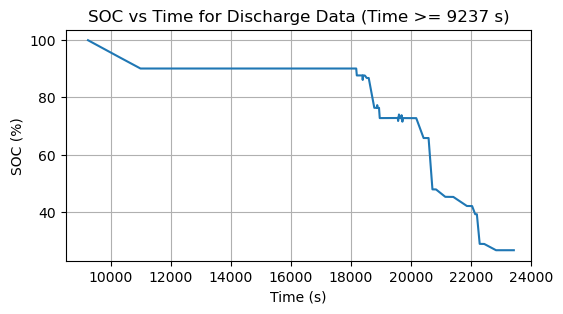

In [9]:
CAPACITY = 2450 # mAh
CAPACITY_C = CAPACITY * 3.6 # Coulombs

voltage_start = BT_discharge['Voltage (V)'].iloc[0]
SOC_start = get_SOC(voltage_start)
print(f"Starting SOC: {round(SOC_start, 2)} % at {voltage_start} V")

charge = CAPACITY * SOC_start/100 * 3.6 # Coulombs
print(f"Starting charge: {round(charge, 2)} C")

# Discharge data
dis_current_array = BT_discharge['Current (mA)'].values
dis_voltage_array = BT_discharge['Voltage (V)'].values

# Coulomb counting
DT = 1 # sec
charge_array = [charge]
for i in range(1, len(dis_current_array)):
    charge += dis_current_array[i]/1000 * DT # C
    charge_array.append(charge)
charge_array = np.array(charge_array)

# Convert charge to SOC
SOC_array = charge_array/CAPACITY_C * 100

fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], SOC_array)
plt.title('SOC vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('SOC (%)')
plt.xlim(8500, 24000)
plt.grid()
plt.show()

#### Calculate v_term(t) by Thevenin Model

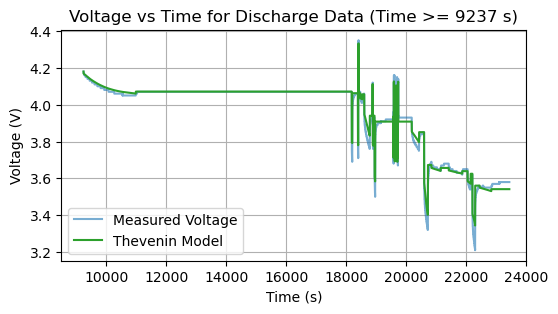

In [10]:
# Thevenin Model
v_term_array = TheveninModel(SOC_array, -dis_current_array/1000)

fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], dis_voltage_array, label='Measured Voltage', alpha=0.6)
plt.plot(BT_discharge['Time (s)'], v_term_array, label='Thevenin Model', color='C2')
plt.title('Voltage vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(8500, 24000)
plt.legend()
plt.grid()
plt.show()

#### Error Calculation

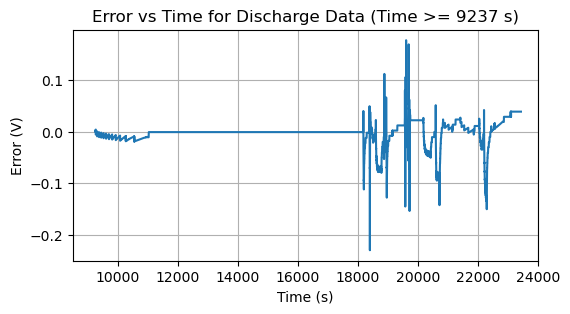

In [11]:
# Error
error_array = dis_voltage_array - v_term_array

fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], error_array)
plt.title('Error vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Error (V)')
plt.xlim(8500, 24000)
plt.grid()
plt.show()